# Solving simple stochastic optimization problems with AMPL
[![newsvendor.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/nfbvs/newsvendor/newsvendor.ipynb)](https://colab.ampl.com)

Description: Examples of the Sample Average Approximation method and risk measures in AMPL

Tags: AMPL, amplpy, Stochastic Optimization, Sample Average Approximation, Risk measures

Notebook author: Nicolau Santos <<nicolau@ampl.com>>

In [1]:
# Install dependencies
%pip install -q amplpy pandas matplotlib numpy

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

This notebook is based on the Gurobi webinar and materials available at
https://www.gurobi.com/events/solving-simple-stochastic-optimization-problems-with-gurobi/
and has examples of the Sample Average Approximation method and risk measures in AMPL.
The original version featured the Gurobi solver. By default, this notebook uses the Highs solver, so that all users are able to change and solve the models in the notebook. It's possible to choose a different solver directly changing the *solver* variable. Note that the MIP in the examples is hard to solve and open source solvers will strugle to find a good solutions for it.

This notebook features the newsvendor problem.
The newsvendor problem has the following characteristics:
 - You have to buy today a stock of products to sell tomorrow.
 - The demand is unknown.
 - It is possible to salvage the remaining stock (sell for scrap).
 
The presented solutions are:
 - Manual solution
 - Maximize expected returns
 - Maximize worst case
 - Maximize worst alpha percentile
 - Minimize Conditionnal Value at Risk (CVaR)
 - Maximize mixture of CVaR and Expected value

In [3]:
import random

from amplpy import AMPL
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter
import numpy
import pandas as pd

random.seed(a=100)
n_bins = 150
dpi = 120
solver = "highs"


# Conditional value at risk (for losses) is the expected value of the worst alpha% tail of the realizations
# in the random variable (represented in this case as a list of values)
# alpha: a value in ]0,1[
# data: a list of values
def CVaR(data, alpha):
    data.sort()
    n = len(data)
    m = int(alpha * n)
    return sum(data[m:-1]) / len(data[m:-1])


# Prints the double histogram of a random variable (represented in this case as a list of values)
# First the empirical density distribution, and then the empirical accumulated probability
def doubleHist(data, xlabel=None):
    # plt.figure(figsize=(14.5,6),dpi=100)
    plt.figure(figsize=(10, 6), dpi=dpi)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], wspace=0.25)
    ax = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax.grid(True)
    ax.set_title(xlabel)
    ax.set_ylabel("Likelihood of occurrence", color="blue")
    ax2 = ax.twinx()
    ax2.set_ylabel("Cumulative probability", color="red")
    # plot the density and cumulative histogram
    n, bins, patches = ax.hist(
        data,
        n_bins,
        density=True,
        alpha=0.65,
        cumulative=False,
        label="Density",
        color="blue",
    )
    n, bins, patches = ax2.hist(
        data,
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="CDF",
        color="red",
    )
    ax3.boxplot(data, vert=False, whis=[5, 95])
    # ax3.axis("off")
    ax3.tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False,
        top=True,
    )
    # tidy up the figure
    plt.show()


# Print basic info on a given solution
def solutionStats(model, losses):
    global cost
    losses.sort()
    samples = len(losses)
    order = model.var["order"].value()
    print(
        "Model Value",
        model.get_objective("obj").value(),
        "order Qty",
        order,
        "investment",
        order * cost,
        "#samples",
        samples,
    )
    print("Losses stats:")
    print(
        "CVaR(95%,90%,80%,70%)",
        CVaR(losses, 0.95),
        CVaR(losses, 0.90),
        CVaR(losses, 0.80),
        CVaR(losses, 0.70),
    )
    print(
        "min",
        min(losses),
        "max",
        max(losses),
        "average",
        sum(losses) / samples,
        "VaR_75%",
        losses[int(0.75 * samples)],
    )


# Build a dataframe with expected values and CVaR values specified in the cvars list
def getTable(data, colnames, cvars):
    info = []
    temp = ["Expected Value"]
    for sol in data:
        temp.append(sum(sol) / len(sol))
    info.append(temp)
    for c in cvars:
        temp = ["CVaR_" + str(c) + "%"]
        for sol in data:
            temp.append(CVaR(sol, c / 100))
        info.append(temp)
    return pd.DataFrame(info, columns=["Metric"] + colnames)


# Get the list of losses from the AMPL instance
def getLosses(ampl):
    return [-v[1] for v in ampl.var["profit"].getValues()]

In [4]:
# Define constants
# Basic economic parameters
# cost: is the procurement cost of each unit
# retail: selling price
# recover: scrap price (if negative is a cost, MUST be smaller than cost, otherwise problem is unbounded!)
cost = 2
retail = 15
recover = -3
# By sampling, we approximate integrals....
# The larger the sample, the more accurate.... but the harder the problem
samples = 10000
# we have a (positive truncated) normal distribution for demand (can't have a negative demand... unless short selling....)
sigma = 100
mu = 400
demand = [max(random.normalvariate(mu, sigma), 0) for i in range(samples)]
# Maximum and minimum revenue. Will be used to bound variables
maxrev = max(demand) * (retail - cost)
minrev = max(demand) * (recover - cost) + min(demand) * retail

## Manual solution

In [5]:
order = 600
losses = [
    -retail * min(order, demand[i]) + cost * order - recover * max(0, order - demand[i])
    for i in range(samples)
]

### Explore solution

Solution Value 4218.884025261554 order Qty 600 investment 1200 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) -548.3178927360779 -1098.2236361473692 -1725.803157600196 -2157.3548113755487
min -7800 max 2301.589271028297 average -4218.884025261554 VaR_75% -3029.6614816227075


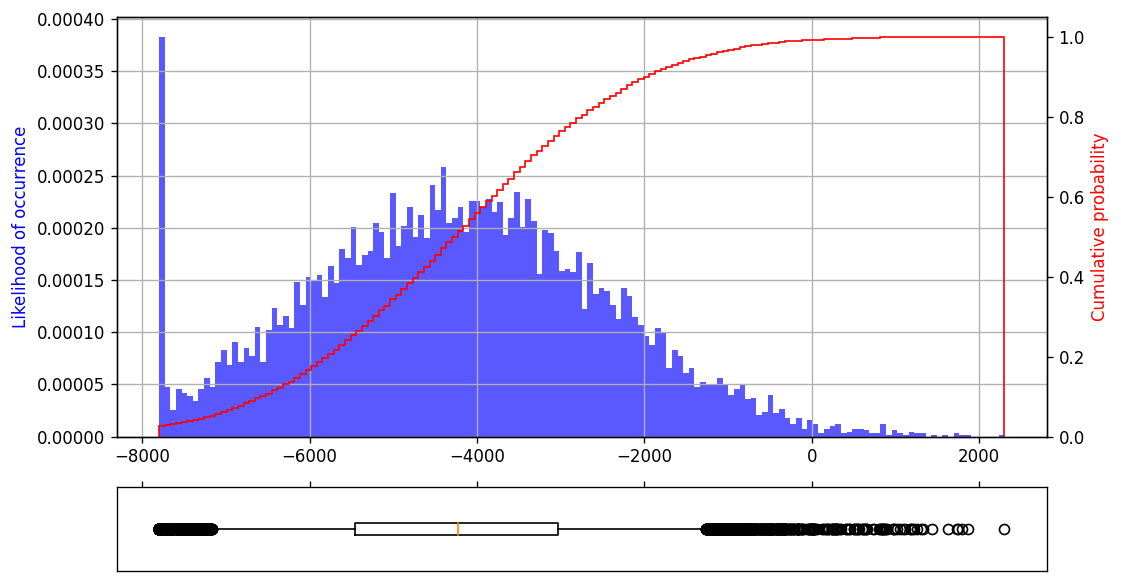

In [6]:
sol = losses.copy()
sol.sort()

print(
    "Solution Value",
    -sum(sol) / len(sol),
    "order Qty",
    order,
    "investment",
    order * cost,
    "#samples",
    samples,
)
print("Losses stats:")
print(
    "CVaR(95%,90%,80%,70%)",
    CVaR(sol, 0.95),
    CVaR(sol, 0.90),
    CVaR(sol, 0.80),
    CVaR(sol, 0.70),
)
print(
    "min",
    min(sol),
    "max",
    max(sol),
    "average",
    sum(sol) / samples,
    "VaR_75%",
    sol[int(0.75 * samples)],
)
doubleHist(sol)

## Maximize expected returns

In [7]:
%%writefile model1.mod

param samples > 0;             # number of samples
param demand{1..samples} >= 0; # demand for each sample
param cost > 0;                # procurement cost of each unit
param retail >= 0;             # selling price of each unit
param recover < cost;          # liquidation price of each unit
param minrev;                  # bound on minimum revenue
param maxrev;                  # bound on maximum revenue

var order >= 0;                                # number of units to order
var sales{i in 1..samples} >= 0, <= demand[i]; # sales of each sample
var discount{1..samples} >= 0;                 # scraped units of each sample
var profit{1..samples} >= minrev, <= maxrev;   # profit of each sample

# maximize average profit across all samples
maximize obj: (1/samples) * sum{i in 1..samples} profit[i];

# profit of each sample
s.t. sample_profit {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
# sales and discount of each sample
s.t. sample_sales {i in 1..samples}: sales[i] + discount[i] == order;

Writing model1.mod


In [8]:
# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("model1.mod")

# Load the data
ampl.param["samples"] = samples
ampl.param["cost"] = cost
ampl.param["recover"] = recover
ampl.param["retail"] = retail
ampl.param["minrev"] = minrev
ampl.param["maxrev"] = maxrev
ampl.param["demand"] = demand

# Set options and solve
ampl.option["solver"] = solver
ampl.option["highs_options"] = "outlev=1"
ampl.solve()

HiGHS 1.5.1: tech:outlev=1
Running HiGHS 1.5.1 [date: 2023-02-27, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
20000 rows, 30001 cols, 70000 nonzeros
20000 rows, 30001 cols, 70000 nonzeros
Presolve : Reductions: rows 20000(-0); columns 30001(-0); elements 70000(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      20000     4.6223579332e+03 Pr: 0(0) 3s
Model   status      : Optimal
Simplex   iterations: 20000
Objective value     :  4.6223579332e+03
HiGHS run time      :          3.41
HiGHS 1.5.1: optimal solution; objective 4622.357933
20000 simplex iterations
0 barrier iterations


### Explore solution

Model Value 4622.357933244379 order Qty 461.2352777789903 investment 922.4705555579806 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) -1242.1415038411253 -1792.0472472524186 -2419.626768705242 -2851.1784224805892
min -5996.058611126874 max 1607.765659923248 average -4622.357933244431 VaR_75% -3723.485092727757


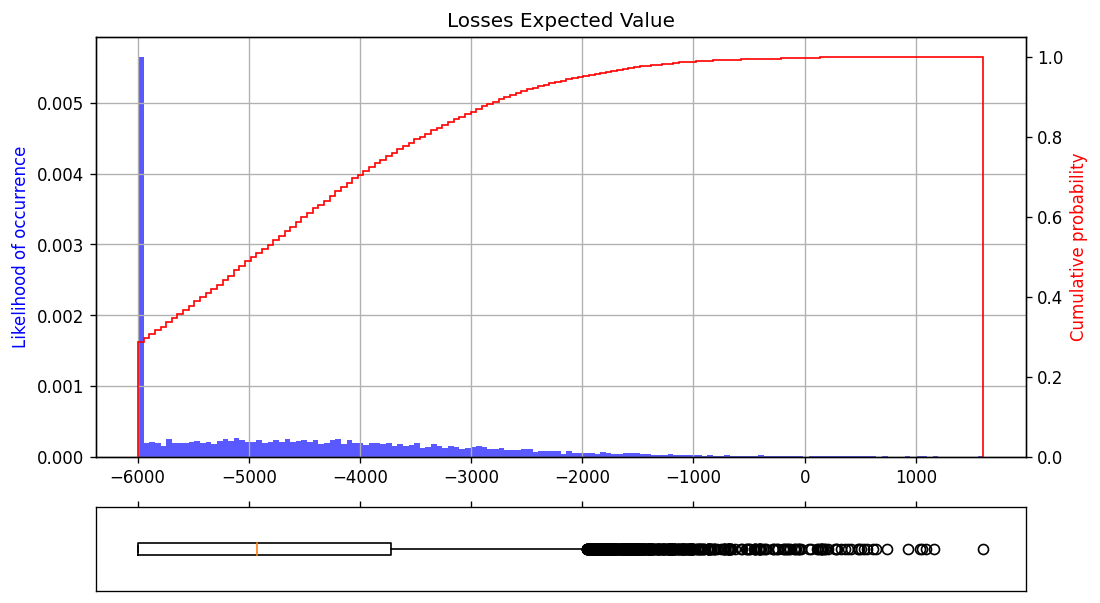

In [9]:
sol1 = getLosses(ampl)
solutionStats(ampl, sol1)
doubleHist(sol1, xlabel="Losses Expected Value")

## Maximize worst case

In [10]:
%%writefile model2.mod

param samples > 0;             # number of samples
param demand{1..samples} >= 0; # demand for each sample
param cost > 0;                # procurement cost of each unit
param retail >= 0;             # selling price of each unit
param recover < cost;          # liquidation price of each unit
param minrev;                  # bound on minimum revenue
param maxrev;                  # bound on maximum revenue

var order >= 0;                                # number of units to order
var sales{i in 1..samples} >= 0, <= demand[i]; # sales of each sample
var discount{1..samples} >= 0;                 # scraped units of each sample
var profit{1..samples} >= minrev, <= maxrev;   # profit of each sample
var worst >= minrev, <= maxrev;                # worst profit

# maximize worst case
maximize obj: worst;  

# profit of each sample
s.t. sample_profit {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
# sales and discount of each sample
s.t. sample_sales {i in 1..samples}: sales[i] + discount[i] == order;
# bound worst across all samples
s.t. worst_case {i in 1..samples}: worst <= profit[i];

Writing model2.mod


In [11]:
# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("model2.mod")

# Load the data
ampl.param["samples"] = samples
ampl.param["cost"] = cost
ampl.param["recover"] = recover
ampl.param["retail"] = retail
ampl.param["minrev"] = minrev
ampl.param["maxrev"] = maxrev
ampl.param["demand"] = demand

# Set options and solve
ampl.option["solver"] = solver
ampl.option["highs_options"] = "outlev=1"
ampl.solve()

HiGHS 1.5.1: tech:outlev=1
Running HiGHS 1.5.1 [date: 2023-02-27, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
30000 rows, 30002 cols, 90000 nonzeros
20040 rows, 20042 cols, 70080 nonzeros
20040 rows, 20042 cols, 70080 nonzeros
Presolve : Reductions: rows 20040(-9960); columns 20042(-9960); elements 70080(-19920)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      10041    -5.0440774870e+02 Pr: 0(0) 1s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 10041
Objective value     :  5.0440774870e+02
HiGHS run time      :          1.13
HiGHS 1.5.1: optimal solution; objective 504.4077487
10041 simplex iterations
0 barrier iterations


### Explore solution

Model Value 504.4077487017854 order Qty 38.8005960539835 investment 77.601192107967 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) -504.40774870178035 -504.40774870179337 -504.40774870177256 -504.40774870176483
min -504.4077487017854 max -504.4077487017854 average -504.40774870189 VaR_75% -504.4077487017854


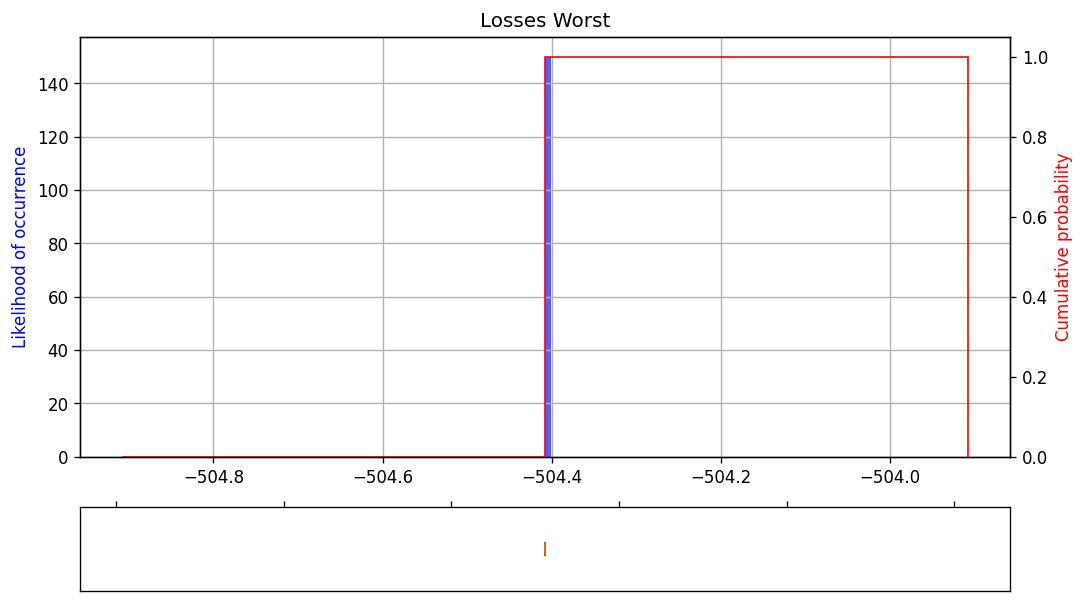

In [12]:
sol2 = getLosses(ampl)
solutionStats(ampl, sol2)
doubleHist(sol2, xlabel="Losses Worst")

## Maximize worst alpha percentile ($\alpha$-**Value at Risk**)

In [13]:
%%writefile model3.mod

param samples > 0;             # number of samples
param demand{1..samples} >= 0; # demand for each sample
param cost > 0;                # procurement cost of each unit
param retail >= 0;             # selling price of each unit
param recover < cost;          # liquidation price of each unit
param minrev;                  # bound on minimum revenue
param maxrev;                  # bound on maximum revenue
param alpha >= 0, <= 1;        # value at risk

var order >= 0;                                # number of units to order
var sales{i in 1..samples} >= 0, <= demand[i]; # sales of each sample
var discount{1..samples} >= 0;                 # scraped units of each sample
var profit{1..samples} >= minrev, <= maxrev;   # profit of each sample
var worst >= minrev, <= maxrev;                # worst profit
var chance{1..samples} binary;                 # chance of each sample

# maximize worst alpha percentile
maximize obj: worst;

# profit of each sample
s.t. sample_profit {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
# sales and discount of each sample
s.t. sample_sales {i in 1..samples}: sales[i] + discount[i] == order;
# relation between worst, chance and profit
s.t. sample_chance {i in 1..samples}: worst - (maxrev - minrev) * chance[i] <= profit[i];
# percentile
s.t. c4: sum{i in 1..samples} chance[i] <= samples * (1 - alpha);

Writing model3.mod


In [14]:
alpha = 0.75

# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("model3.mod")

# Load the data
ampl.param["samples"] = samples
ampl.param["cost"] = cost
ampl.param["recover"] = recover
ampl.param["retail"] = retail
ampl.param["minrev"] = minrev
ampl.param["maxrev"] = maxrev
ampl.param["demand"] = demand
ampl.param["alpha"] = alpha

# Set options and solve
ampl.option["solver"] = solver
ampl.option["highs_options"] = "outlev=1 timelim=60.0"
ampl.solve()

HiGHS 1.5.1: tech:outlev=1
lim:time=60
Running HiGHS 1.5.1 [date: 2023-02-27, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
30001 rows, 40002 cols, 110000 nonzeros
30001 rows, 40002 cols, 100000 nonzeros

Solving MIP model with:
   30001 rows
   40002 cols (10000 binary, 0 integer, 0 implied int., 30002 continuous)
   100000 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   10067.433634    -inf                 inf        0      0      0         0    13.4s
 R       0       0         0   0.00%   10067.433634    874.5936399     1051.10%        0      0      0     36169    61.0s

Solving report
  Status            Time limit reached
  Primal bound      874.593639936
  Dual bound        10067.4336338
  Gap       

### Explore solution

Model Value 874.593639936231 order Qty 67.27643384124855 investment 134.5528676824971 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) 336.3821692062457 336.38216920624063 126.77855241620063 -207.12347904508792
min -874.593639936231 max 336.3821692062427 average -674.2982411040476 VaR_75% -874.593639936231


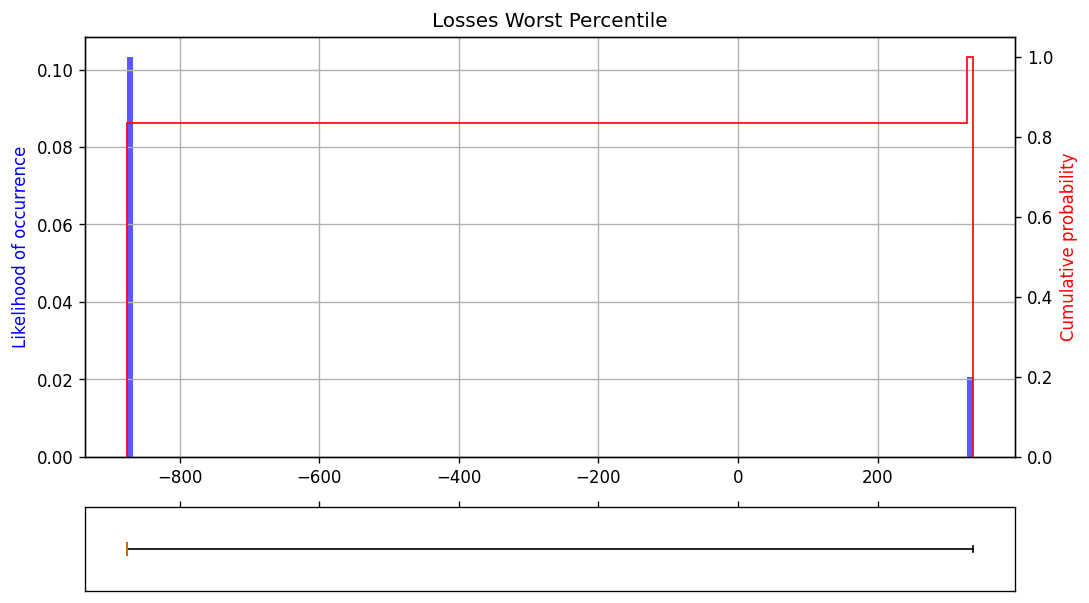

In [15]:
sol3 = getLosses(ampl)
solutionStats(ampl, sol3)
doubleHist(sol3, xlabel="Losses Worst Percentile")

## Minimize Conditional Value at Risk ($CVaR_\alpha$)

In [16]:
%%writefile model4.mod

param samples > 0;             # number of samples
param demand{1..samples} >= 0; # demand for each sample
param cost > 0;                # procurement cost of each unit
param retail >= 0;             # selling price of each unit
param recover < cost;          # liquidation price of each unit
param minrev;                  # bound on minimum revenue
param maxrev;                  # bound on maximum revenue
param alpha >= 0, <= 1;        # value at risk

var order >= 0;                                # number of units to order
var sales{i in 1..samples} >= 0, <= demand[i]; # sales of each sample
var discount{1..samples} >= 0;                 # scraped units of each sample
var profit{1..samples} >= minrev, <= maxrev;   # profit of each sample
var nu >= minrev, <= maxrev;
var excess{1..samples} >= 0, <= maxrev - minrev;

# minimize CVaR
minimize obj: nu + (1.0 / ((1 - alpha) * samples)) * sum{i in 1..samples} excess[i];

# profit of each sample
s.t. sample_profit {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
# sales and discount of each sample
s.t. sample_sales {i in 1..samples}: sales[i] + discount[i] == order;
# relation between excess and profit of each sample
s.t. sample_excess {i in 1..samples}: -profit[i] - nu <= excess[i];

Writing model4.mod


In [17]:
alpha = 0.75

# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("model4.mod")

# Load the data
ampl.param["samples"] = samples
ampl.param["cost"] = cost
ampl.param["recover"] = recover
ampl.param["retail"] = retail
ampl.param["minrev"] = minrev
ampl.param["maxrev"] = maxrev
ampl.param["demand"] = demand
ampl.param["alpha"] = alpha

# Set options and solve
ampl.option["solver"] = solver
ampl.option["highs_options"] = "outlev=1"
ampl.solve()

HiGHS 1.5.1: tech:outlev=1
Running HiGHS 1.5.1 [date: 2023-02-27, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
30000 rows, 40002 cols, 100000 nonzeros
30000 rows, 40002 cols, 100000 nonzeros
Presolve : Reductions: rows 30000(-0); columns 40002(-0); elements 100000(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.3023918373e+03 Pr: 20000(5.14075e+06) 0s
       9330    -3.2924042645e+03 Pr: 11868(1.37834e+06) 5s
      28358    -3.0786916352e+03 Pr: 0(0); Du: 2(0.322954) 10s
      30651    -3.0786916352e+03 Pr: 0(0) 13s
      30651    -3.0786916352e+03 Pr: 0(0) 13s
Model   status      : Optimal
Simplex   iterations: 30651
Objective value     : -3.0786916352e+03
HiGHS run time      :         13.56
HiGHS 1.5.1: optimal solution; objective -3078.691635
30651 simplex iterations
0 barrier iterations


### Explore solution

Model Value -3078.691635183291 order Qty 253.0831475661703 investment 506.1662951323406 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) -2282.902154905224 -2764.9396550818556 -3027.641637712309 -3115.1505675716676
min -3290.080918360214 max 567.0050088591486 average -3237.233597566205 VaR_75% -3290.080918360214


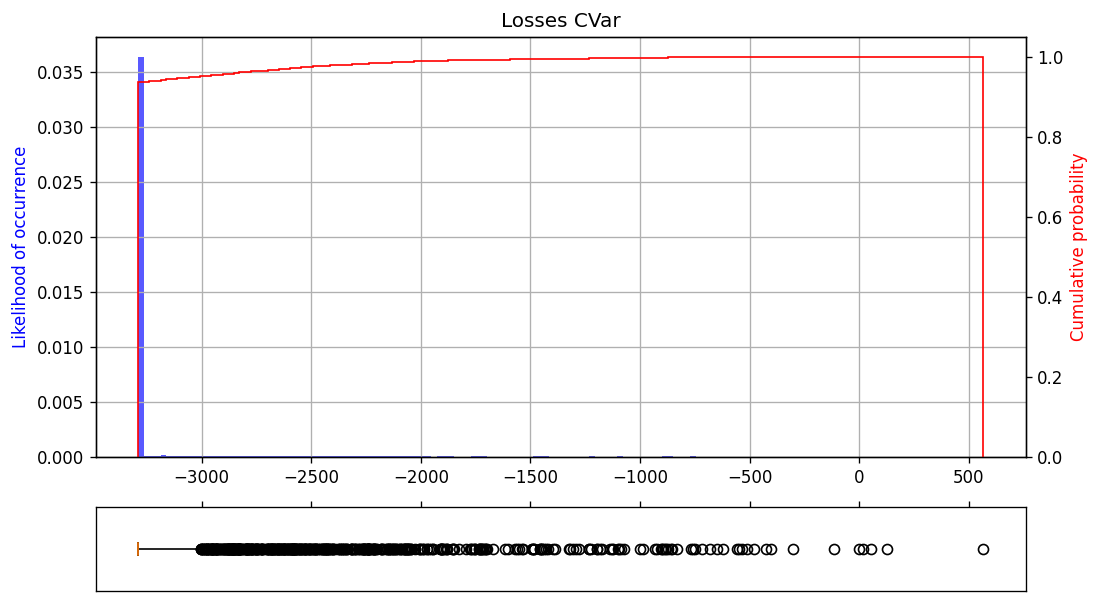

In [18]:
sol4 = getLosses(ampl)
solutionStats(ampl, sol4)
doubleHist(sol4, xlabel="Losses CVar")

## Mixture of CVaR and Expected value

In [19]:
%%writefile model5.mod

param samples > 0;             # number of samples
param demand{1..samples} >= 0; # demand for each sample
param cost > 0;                # procurement cost of each unit
param retail >= 0;             # selling price of each unit
param recover < cost;          # liquidation price of each unit
param minrev;                  # bound on minimum revenue
param maxrev;                  # bound on maximum revenue
param alpha >= 0, <= 1;        # value at risk
param beta >= 0, <= 1;         # weight between expected value and CVaR

var order >= 0;                                # number of units to order
var sales{i in 1..samples} >= 0, <= demand[i]; # sales of each sample
var discount{1..samples} >= 0;                 # scraped units of each sample
var profit{1..samples} >= minrev, <= maxrev;   # profit of each sample
var nu >= minrev, <= maxrev;
var excess{1..samples} >= 0, <= maxrev - minrev;

# maximize weighted sum of expected value and CVaR
maximize obj:
    - beta * nu
    - (beta / ((1 - alpha) * samples)) * sum{i in 1..samples} excess[i]
    + ((1-beta)/samples) * sum{i in 1..samples} profit[i];

# profit of each sample
s.t. sample_profit {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
# sales and discount of each sample
s.t. sample_sales {i in 1..samples}: sales[i] + discount[i] == order;
# relation between excess and profit of each sample
s.t. sample_excess {i in 1..samples}: -profit[i] - nu <= excess[i];

Writing model5.mod


In [20]:
beta = 0.50
alpha = 0.75

# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("model5.mod")

# Load the data
ampl.param["samples"] = samples
ampl.param["cost"] = cost
ampl.param["recover"] = recover
ampl.param["retail"] = retail
ampl.param["minrev"] = minrev
ampl.param["maxrev"] = maxrev
ampl.param["demand"] = demand
ampl.param["alpha"] = alpha
ampl.param["beta"] = beta

# Set options and solve
ampl.option["solver"] = solver
ampl.option["highs_options"] = "outlev=1"
ampl.solve()

HiGHS 1.5.1: tech:outlev=1
Running HiGHS 1.5.1 [date: 2023-02-27, git hash: 93f1876]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
30000 rows, 40002 cols, 100000 nonzeros
30000 rows, 40002 cols, 100000 nonzeros
Presolve : Reductions: rows 30000(-0); columns 40002(-0); elements 100000(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      18511     3.7045413447e+03 Pr: 5442(14570.3) 5s
      21520     3.6476039870e+03 Pr: 0(0) 7s
      21520     3.6476039870e+03 Pr: 0(0) 7s
Model   status      : Optimal
Simplex   iterations: 21520
Objective value     :  3.6476039870e+03
HiGHS run time      :          7.46
HiGHS 1.5.1: optimal solution; objective 3647.603987
21520 simplex iterations
0 barrier iterations


### Explore solution

Model Value 3647.6039869767988 order Qty 415.1543649507064 investment 830.3087299014128 #samples 10000
Losses stats:
CVaR(95%,90%,80%,70%) -1472.5460679825462 -2022.4518113938377 -2650.031332846664 -3081.582986622015
min -5397.006744359185 max 1377.361095781829 average -4554.551834745325 VaR_75% -3953.889656869175


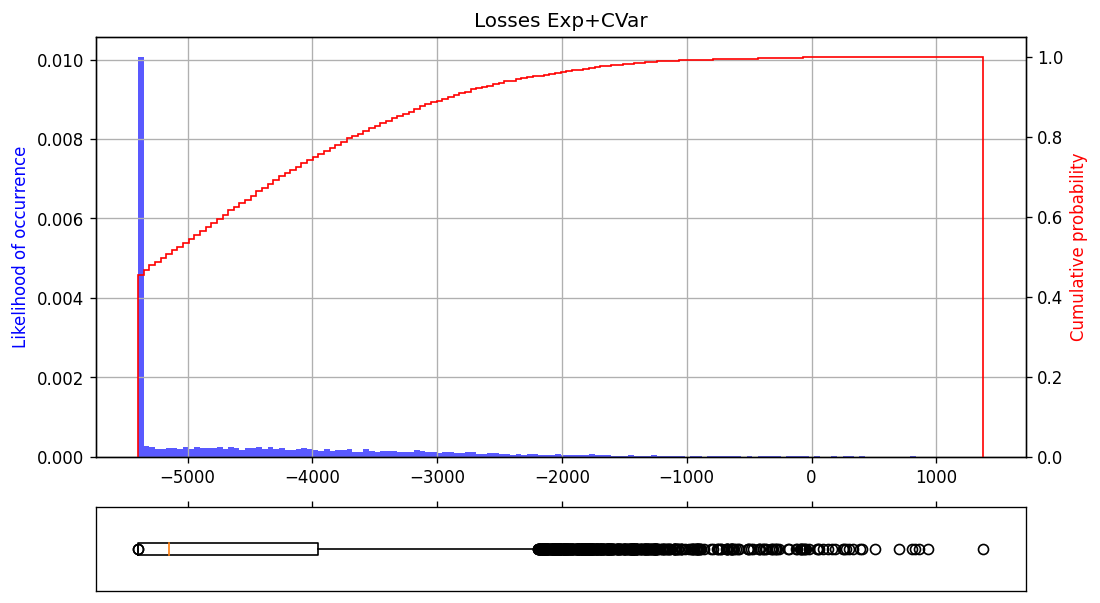

In [21]:
sol5 = getLosses(ampl)
solutionStats(ampl, sol5)
doubleHist(sol5, xlabel="Losses Exp+CVar")

## Comparing solution approaches and behavior

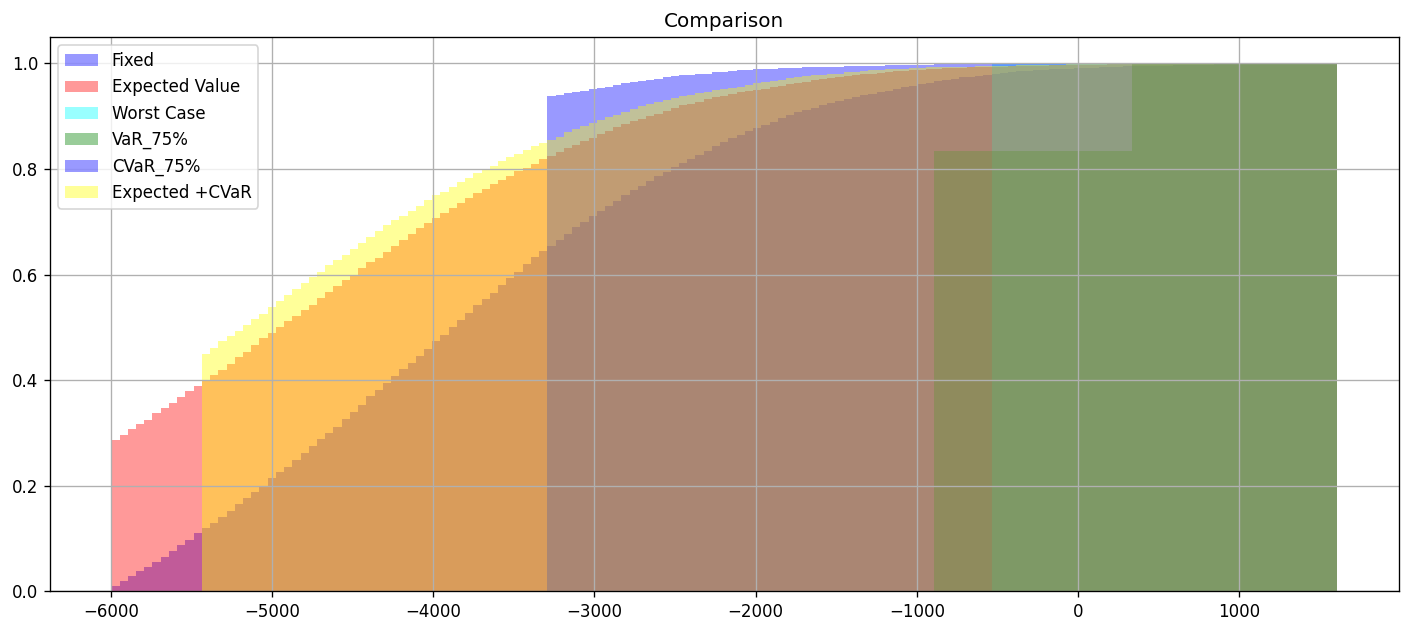

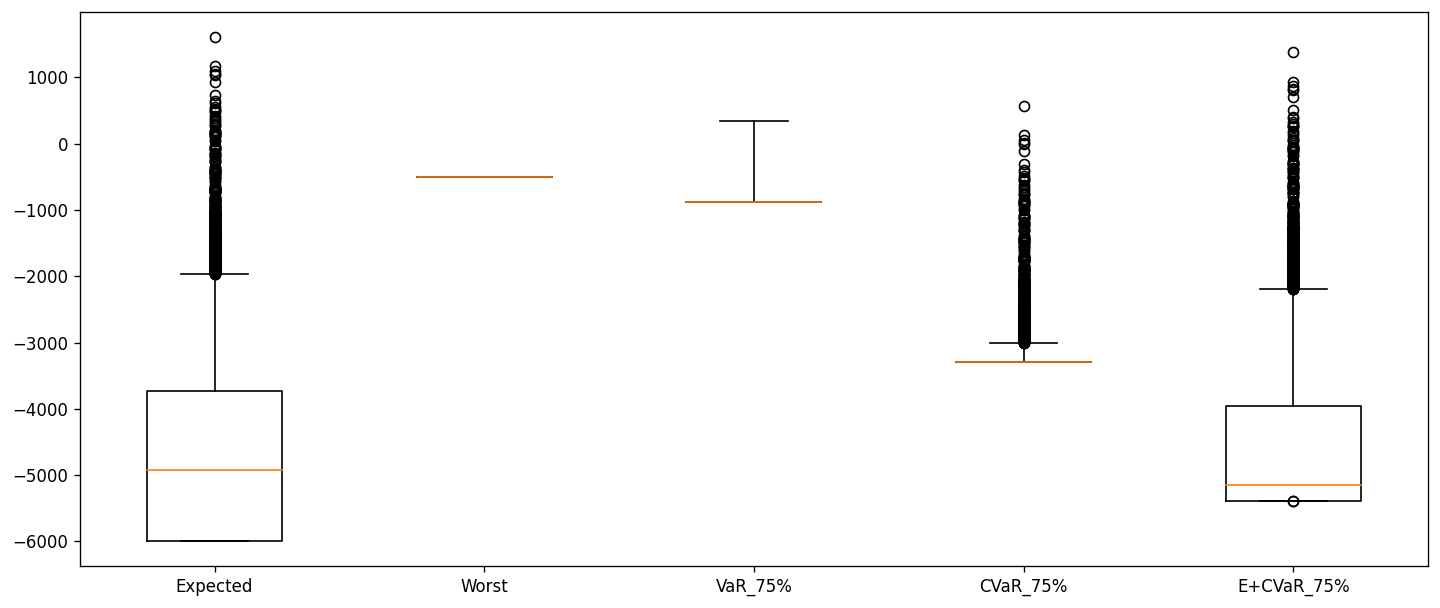

In [22]:
fig, ax = plt.subplots(figsize=(14.5, 6), dpi=dpi)
xmin = min(sol1 + sol2 + sol3 + sol4 + sol5)
xmax = max(sol1 + sol2 + sol3 + sol4 + sol5)
bins = numpy.linspace(xmin, xmax, 150)
ax.grid(True)
ax.set_title("Comparison")
d = True
c = True
a = 0.4
# plot the density and cumulative histogram
n, bins2, patches = ax.hist(
    sol, bins, alpha=a, density=d, cumulative=c, label="Fixed", color="blue"
)
n, bins2, patches = ax.hist(
    sol1, bins, alpha=a, density=d, cumulative=c, label="Expected Value", color="red"
)
n, bins2, patches = ax.hist(
    sol2, bins, alpha=a, density=d, cumulative=c, label="Worst Case", color="cyan"
)
n, bins2, patches = ax.hist(
    sol3, bins, alpha=a, density=d, cumulative=c, label="VaR_75%", color="green"
)
n, bins2, patches = ax.hist(
    sol4, bins, alpha=a, density=d, cumulative=c, label="CVaR_75%", color="blue"
)
n, bins2, patches = ax.hist(
    sol5, bins, alpha=a, density=d, cumulative=c, label="Expected +CVaR", color="yellow"
)
# tidy up the figure
ax.legend(loc="upper left")
plt.show()

data = [sol1, sol2, sol3, sol4, sol5]
plt.figure(figsize=(14.5, 6), dpi=dpi)
plt.boxplot(data, whis=[5, 95])
plt.xticks([1, 2, 3, 4, 5], ["Expected", "Worst", "VaR_75%", "CVaR_75%", "E+CVaR_75%"])
plt.show()

In [23]:
data = [sol1, sol2, sol3, sol4, sol5]
colnames = ["Expected", "Worst", "VaR_75%", "CVaR_75%", "Ex+CVaR_75%"]
cvars = [70, 80, 90, 95]

display(getTable(data, colnames, cvars))

,Metric,Expected,Worst,VaR_75%,CVaR_75%,Ex+CVaR_75%
0,Expected Value,-4622.357933,-504.407749,-674.298241,-3237.233598,-4554.551835
1,CVaR_70%,-2851.178422,-504.407749,-207.123479,-3115.150568,-3081.582987
2,CVaR_80%,-2419.626769,-504.407749,126.778552,-3027.641638,-2650.031333
3,CVaR_90%,-1792.047247,-504.407749,336.382169,-2764.939655,-2022.451811
4,CVaR_95%,-1242.141504,-504.407749,336.382169,-2282.902155,-1472.546068
